# togo EDA Notebook

This notebook performs Exploratory Data Analysis (EDA) on the Benin solar and weather dataset using modularized functions from the `src` directory.

## Importing Packages

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
# Add the parent directory (benin_eda_project/) to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
import pandas as pd
from src.data_loader import load_data
from src.data_transformer import convert_timestamp, cap_wind_speeds, impute_missing_values
from src.data_analyzer import get_summary_statistics, detect_negative_values, detect_missing_values, detect_outliers, check_unrealistic_wind_speeds
from src.visualizer import plot_distributions, plot_boxplots, plot_combined_visuals
from src.utils import save_dataframe
# Debug: Print current working directory and Python path
print('Current working directory:', os.getcwd())
print('Python path:', sys.path)

Current working directory: e:\KAIM\solar-challenge-week1\notebooks
Python path: ['C:\\Program Files\\Python312\\python312.zip', 'C:\\Program Files\\Python312\\DLLs', 'C:\\Program Files\\Python312\\Lib', 'C:\\Program Files\\Python312', 'e:\\KAIM\\solar-challenge-week1\\venv', '', 'e:\\KAIM\\solar-challenge-week1\\venv\\Lib\\site-packages', 'e:\\KAIM\\solar-challenge-week1\\venv\\Lib\\site-packages\\win32', 'e:\\KAIM\\solar-challenge-week1\\venv\\Lib\\site-packages\\win32\\lib', 'e:\\KAIM\\solar-challenge-week1\\venv\\Lib\\site-packages\\Pythonwin', 'e:\\KAIM\\solar-challenge-week1']


## Extract

In [3]:
# Load data
file_path = os.path.join('..', 'data', 'togo-dapaong_qc.csv')
df = load_data(file_path)
df.head()

2025-05-18 17:41:31,432 - INFO - Successfully loaded data from ..\data\togo-dapaong_qc.csv with 525600 rows


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-10-25 00:01,-1.3,0.0,0.0,0.0,0.0,24.8,94.5,0.9,1.1,0.4,227.6,1.1,977,0,0.0,24.7,24.4,NaN
1,2021-10-25 00:02,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.1,1.6,0.4,229.3,0.7,977,0,0.0,24.7,24.4,NaN
2,2021-10-25 00:03,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.2,1.4,0.3,228.5,2.9,977,0,0.0,24.7,24.4,NaN
3,2021-10-25 00:04,-1.2,0.0,0.0,0.0,0.0,24.8,94.3,1.2,1.6,0.3,229.1,4.6,977,0,0.0,24.7,24.4,NaN
4,2021-10-25 00:05,-1.2,0.0,0.0,0.0,0.0,24.8,94.0,1.3,1.6,0.4,227.5,1.6,977,0,0.0,24.7,24.4,NaN


## Data Profiling

### Summary Statistics

In [4]:
# Summary statistics
print("Summary Statistics:")
stats = get_summary_statistics(df)
print(stats)

Summary Statistics:


2025-05-18 17:41:40,174 - INFO - Computed summary statistics


                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      230.555040     151.258469     116.444352     226.144375   
std       322.532347     250.956962     156.520714     317.346938   
min       -12.700000       0.000000       0.000000       0.000000   
25%        -2.200000       0.000000       0.000000       0.000000   
50%         2.100000       0.000000       2.500000       4.400000   
75%       442.400000     246.400000     215.700000     422.525000   
max      1424.000000    1004.500000     805.700000    1380.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      219.568588      27.751788      55.013160       2.368093   
std       307.932510       4.758023      28.778732       1.462668   
min         0.000000      14.900000       3.300000       0.000000   
25%         0.000000      24.2000

### Negative Values Check

- **GHI, DNI, DHI**: Solar irradiance measurements must be non-negative.
- **ModA, ModB**: Sensor readings should be >= 0.
- **WS, WSgust, Precipitation**: Physical quantities that cannot be negative.
- **BP**: Barometric pressure should not be 0.
- **Comments**: Fully null, consider dropping.

In [5]:
# Check for negative values
columns = ['GHI', 'DNI', 'DHI', 'Tamb', 'WS', 'ModA', 'ModB', 'BP', 'Precipitation']
negative_counts = detect_negative_values(df, columns)
print("Negative Values:")
print(negative_counts)

2025-05-18 17:41:47,197 - INFO - Detected negative values


Negative Values:
GHI              257385
DNI                   0
DHI                   0
Tamb                  0
WS                    0
ModA                  0
ModB                  0
BP                    0
Precipitation         0
dtype: int64


 • GHI, DNI, and DHI: These are measurements of solar irradiance and must be non-negative because energy isn’t negative.(There is issue need further analysis and fix)

 • ModA and ModB: These sensor readings represent irradiance-like values and should always be ≥ 0. (Valid)

 •  WS, WSgust, and Precipitation: These metric values are physical quantities that naturally can’t be negative.(Valid)

 • Column That Should Not Be 0: • Barometric Pressure (BP): A reading of 0 hPa is physically unrealistic, so if BP is 0, it likely indicates a sensor error or data issue.(No 0 value so valid)

 • column Comments shows full null column it should be droped or fixed


### Missing Values

In [6]:
# Missing value detection
print("\nMissing Value Detection:")
missing_counts, missing_percentages = detect_missing_values(df)
print("Count of missing values:\n", missing_counts)
print("Percentage of missing values:\n", missing_percentages.round(2))

2025-05-18 17:42:03,813 - INFO - Detected missing values



Missing Value Detection:
Count of missing values:
 Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64
Percentage of missing values:
 Timestamp          0.0
GHI                0.0
DNI                0.0
DHI                0.0
ModA               0.0
ModB               0.0
Tamb               0.0
RH                 0.0
WS                 0.0
WSgust             0.0
WSstdev            0.0
WD                 0.0
WDstdev            0.0
BP                 0.0
Cleaning           0.0
Precipitation      0.0
TModA              0.0
TModB              0.0
Comments         100.0
dtype: floa

No Explicit missing (NaN) values column in the dataset except Comments column so niether imputation nor drop needed here

### Data Types

In [7]:
# Data type identification
print("\nData Type Identification:")
print(df.dtypes)


Data Type Identification:
Timestamp         object
GHI              float64
DNI              float64
DHI              float64
ModA             float64
ModB             float64
Tamb             float64
RH               float64
WS               float64
WSgust           float64
WSstdev          float64
WD               float64
WDstdev          float64
BP                 int64
Cleaning           int64
Precipitation    float64
TModA            float64
TModB            float64
Comments         float64
dtype: object


Timestamp should be datetime, not object(strings) should be convert to datetime 

## Distribution and Outlier Analysis

In [8]:
# Define key columns
key_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

In [9]:


# Plot distributions
#plot_distributions(df, key_cols, output_dir=os.path.join('..', 'plots'))

# Plot boxplots
#plot_boxplots(df, key_cols, output_dir=os.path.join('..', 'plots'))
# Plot combined histograms and boxplots
plot_combined_visuals(df, key_cols, output_dir=os.path.join('..', 'plots/togo'))

2025-05-18 17:42:34,958 - INFO - Saved combined plot for GHI to ..\plots/togo\GHI_combined_plot_benin.png
2025-05-18 17:42:39,686 - INFO - Saved combined plot for DNI to ..\plots/togo\DNI_combined_plot_benin.png
2025-05-18 17:42:43,881 - INFO - Saved combined plot for DHI to ..\plots/togo\DHI_combined_plot_benin.png
2025-05-18 17:42:48,294 - INFO - Saved combined plot for ModA to ..\plots/togo\ModA_combined_plot_benin.png
2025-05-18 17:42:52,789 - INFO - Saved combined plot for ModB to ..\plots/togo\ModB_combined_plot_benin.png
2025-05-18 17:42:55,836 - INFO - Saved combined plot for WS to ..\plots/togo\WS_combined_plot_benin.png
2025-05-18 17:42:58,550 - INFO - Saved combined plot for WSgust to ..\plots/togo\WSgust_combined_plot_benin.png


In [10]:
# Detect outliers
outliers = detect_outliers(df, key_cols)
print(f"\nNumber of outlier rows (|Z|>3): {len(outliers)}")
if len(outliers) > 0:
    print("Outlier rows:")
    print(outliers)

# Save outliers
# save_dataframe(outliers, os.path.join('..', 'data', 'outliers_zscore.csv'))

2025-05-18 17:43:44,290 - INFO - Detected 9251 outlier rows with |Z|>3



Number of outlier rows (|Z|>3): 9251
Outlier rows:
           GHI    DNI    DHI    ModA    ModB   WS  WSgust
4985    1139.0  805.1  466.1  1172.0  1154.0  2.2     2.6
5410      -1.2    0.0    0.0     0.0     0.0  6.6     9.7
5411      -1.0    0.0    0.0     0.0     0.0  6.9     8.9
5413      -0.8    0.0    0.0     0.0     0.0  7.1     8.9
5420      -1.3    0.0    0.0     0.0     0.0  6.1     8.9
...        ...    ...    ...     ...     ...  ...     ...
510473   709.5   63.7  629.8   703.1   694.9  3.5     4.4
510474   677.8   40.6  621.7   670.1   662.2  2.8     3.6
510475   659.5   29.7  614.9   651.0   643.4  4.1     4.9
510476   660.1   40.7  605.6   653.2   645.6  3.7     4.6
510477   655.8   50.2  591.0   647.5   639.9  3.4     5.9

[9251 rows x 7 columns]


Why Median Imputation?

Skewed Data: The data is right-skewed, so the median is a better central tendency measure than the mean, which would be biased by the long tail.

Time Series: Dropping rows could disrupt time series analysis (e.g., gaps in timestamps), so imputation is preferred unless missingness is excessive (>5% as per the task).

## Transform

In [11]:
# Convert Timestamp to datetime
df = convert_timestamp(df)
df.dtypes

2025-05-18 17:43:54,117 - INFO - Converted Timestamp to datetime and extracted Hour


Timestamp        datetime64[ns]
GHI                     float64
DNI                     float64
DHI                     float64
ModA                    float64
ModB                    float64
Tamb                    float64
RH                      float64
WS                      float64
WSgust                  float64
WSstdev                 float64
WD                      float64
WDstdev                 float64
BP                        int64
Cleaning                  int64
Precipitation           float64
TModA                   float64
TModB                   float64
Comments                float64
Hour                      int32
dtype: object

In [12]:
# Impute missing values
df = impute_missing_values(df, key_cols)

# Verify no missing values
print("\nMissing Values After Imputation:")
print(df[key_cols].isna().sum())


Missing Values After Imputation:
GHI       0
DNI       0
DHI       0
ModA      0
ModB      0
WS        0
WSgust    0
dtype: int64


## Load

In [13]:
# Save cleaned data
save_dataframe(df, os.path.join('..', 'data', 'togo_clean.csv'))

2025-05-18 17:44:16,427 - INFO - Saved DataFrame to ..\data\togo_clean.csv


## EDA

In [14]:
# Load cleaned data
clean_file_path = os.path.join('..', 'data', 'togo_clean.csv')
df_clean = load_data(clean_file_path)
df_clean.head()

2025-05-18 17:44:36,398 - INFO - Successfully loaded data from ..\data\togo_clean.csv with 525600 rows


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments,Hour
0,2021-10-25 00:01:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.5,0.9,1.1,0.4,227.6,1.1,977,0,0.0,24.7,24.4,NaN,0
1,2021-10-25 00:02:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.1,1.6,0.4,229.3,0.7,977,0,0.0,24.7,24.4,NaN,0
2,2021-10-25 00:03:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.2,1.4,0.3,228.5,2.9,977,0,0.0,24.7,24.4,NaN,0
3,2021-10-25 00:04:00,-1.2,0.0,0.0,0.0,0.0,24.8,94.3,1.2,1.6,0.3,229.1,4.6,977,0,0.0,24.7,24.4,NaN,0
4,2021-10-25 00:05:00,-1.2,0.0,0.0,0.0,0.0,24.8,94.0,1.3,1.6,0.4,227.5,1.6,977,0,0.0,24.7,24.4,NaN,0


In [15]:
df_clean = convert_timestamp(df)
df_clean.dtypes

2025-05-18 17:44:40,925 - INFO - Converted Timestamp to datetime and extracted Hour


Timestamp        datetime64[ns]
GHI                     float64
DNI                     float64
DHI                     float64
ModA                    float64
ModB                    float64
Tamb                    float64
RH                      float64
WS                      float64
WSgust                  float64
WSstdev                 float64
WD                      float64
WDstdev                 float64
BP                        int64
Cleaning                  int64
Precipitation           float64
TModA                   float64
TModB                   float64
Comments                float64
Hour                      int32
dtype: object

In [16]:
# Debugging: Check for invalid timestamps (NaT)
print("\nNumber of invalid timestamps (NaT):", df_clean['Timestamp'].isna().sum())


Number of invalid timestamps (NaT): 0


In [17]:
# Define key columns for time series analysis
time_series_cols = ['GHI', 'DNI', 'DHI', 'Tamb']

In [18]:
# Set Timestamp as index
df_clean.set_index('Timestamp', inplace=True)

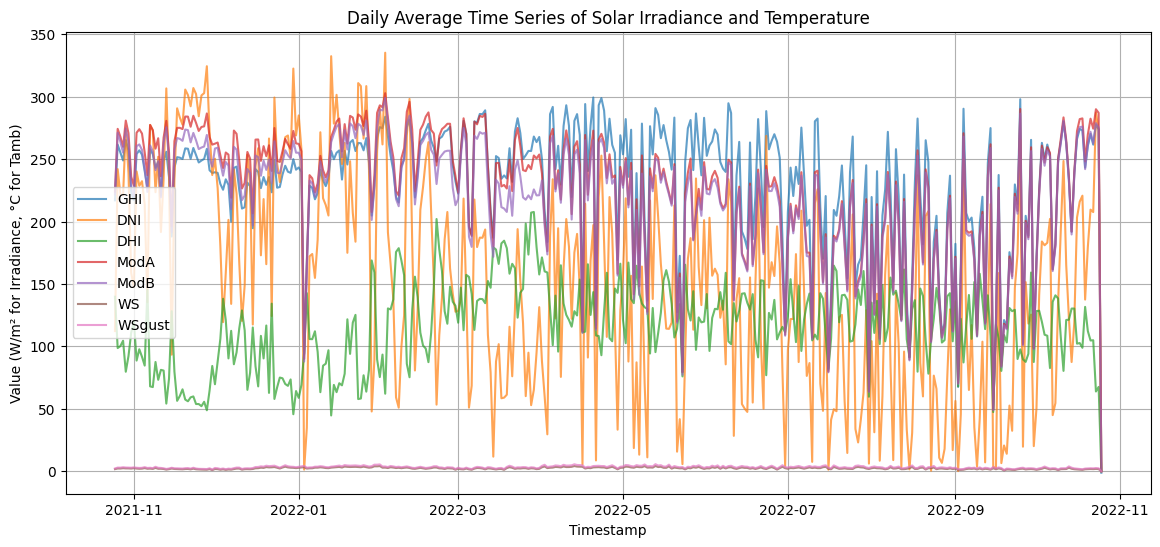

In [19]:
# 1. Downsampled time series (daily averages)
daily_avg = df_clean[key_cols].resample('D').mean().reset_index()

plt.figure(figsize=(14, 6))
for col in key_cols:
    plt.plot(daily_avg['Timestamp'], daily_avg[col], label=col, alpha=0.7)
plt.title('Daily Average Time Series of Solar Irradiance and Temperature')
plt.xlabel('Timestamp')
plt.ylabel('Value (W/m² for Irradiance, °C for Tamb)')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\Naod.Amare\AppData\Local\Temp\ipykernel_16396\60189528.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df_clean[key_cols].resample('M').mean()


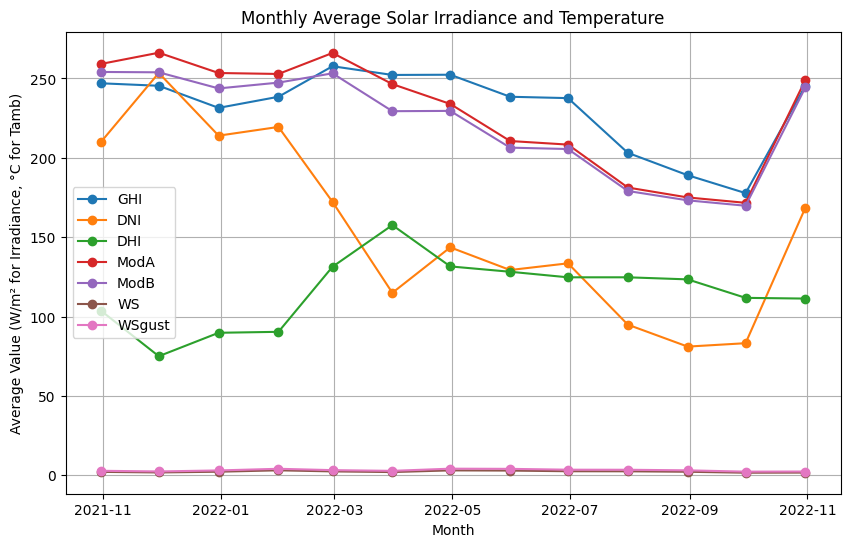

In [21]:
# 2. Monthly averages
monthly_avg = df_clean[key_cols].resample('M').mean()

plt.figure(figsize=(10, 6))
for col in key_cols:
    plt.plot(monthly_avg.index, monthly_avg[col], label=col, marker='o')
plt.title('Monthly Average Solar Irradiance and Temperature')
plt.xlabel('Month')
plt.ylabel('Average Value (W/m² for Irradiance, °C for Tamb)')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# 4. Anomaly detection (e.g., peaks in GHI > 1000 W/m² or Tamb > 40°C)
ghi_anomalies = df_clean[df_clean['GHI'] > 1000][['GHI']]
dni_anomalies = df_clean[df_clean['DNI'] > 1000][['DNI']]
tamb_anomalies = df_clean[df_clean['Tamb'] > 40][['Tamb']]

print("\nGHI Anomalies (>1000 W/m²):")
print(ghi_anomalies)
print("\nDNI Anomalies (>1000 W/m²):")
print(dni_anomalies)
print("\nTamb Anomalies (>40°C):")
print(tamb_anomalies)


GHI Anomalies (>1000 W/m²):
                        GHI
Timestamp                  
2021-10-25 11:15:00  1094.0
2021-10-25 11:16:00  1085.0
2021-10-25 11:22:00  1028.0
2021-10-25 11:23:00  1007.0
2021-10-25 11:24:00  1008.0
...                     ...
2022-10-22 13:20:00  1022.0
2022-10-22 13:21:00  1026.0
2022-10-22 13:22:00  1060.0
2022-10-22 13:28:00  1040.0
2022-10-22 13:29:00  1024.0

[5812 rows x 1 columns]

DNI Anomalies (>1000 W/m²):
                        DNI
Timestamp                  
2022-02-02 12:44:00  1004.5

Tamb Anomalies (>40°C):
                     Tamb
Timestamp                
2022-03-03 14:52:00  40.1
2022-03-03 14:53:00  40.2
2022-03-03 14:54:00  40.3
2022-03-03 14:55:00  40.2
2022-03-03 14:56:00  40.1
...                   ...
2022-04-10 15:54:00  40.1
2022-04-10 15:56:00  40.1
2022-04-10 15:57:00  40.1
2022-04-24 15:23:00  40.1
2022-04-24 15:24:00  40.1

[674 rows x 1 columns]


In [23]:
# Debugging: Check if Cleaning column exists and its values
print("Columns in dataset:", df_clean.columns.tolist())
print("\nSample of Cleaning column:")
print(df_clean['Cleaning'].head())
print("\nUnique values in Cleaning column:", df_clean['Cleaning'].unique())

Columns in dataset: ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation', 'TModA', 'TModB', 'Comments', 'Hour']

Sample of Cleaning column:
Timestamp
2021-10-25 00:01:00    0
2021-10-25 00:02:00    0
2021-10-25 00:03:00    0
2021-10-25 00:04:00    0
2021-10-25 00:05:00    0
Name: Cleaning, dtype: int64

Unique values in Cleaning column: [0 1]


In [24]:
# Group by Cleaning flag and calculate average ModA and ModB
cleaning_impact = df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean()

<Figure size 800x600 with 0 Axes>

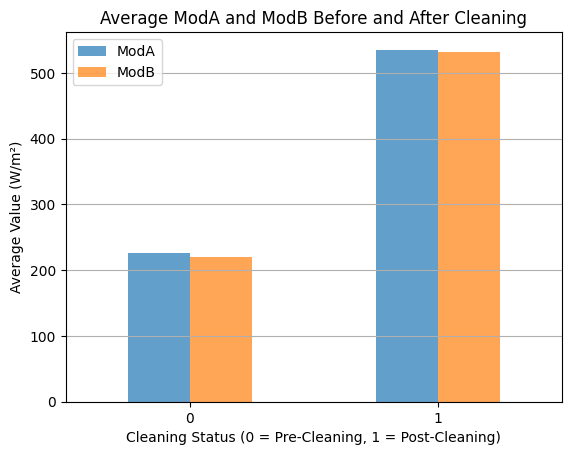


Average ModA and ModB by Cleaning Status:
                ModA        ModB
Cleaning                        
0         225.979064  219.401351
1         535.186477  532.211744


In [25]:
# Plot average ModA and ModB pre/post-cleaning
plt.figure(figsize=(8, 6))
cleaning_impact.plot(kind='bar', alpha=0.7)
plt.title('Average ModA and ModB Before and After Cleaning')
plt.xlabel('Cleaning Status (0 = Pre-Cleaning, 1 = Post-Cleaning)')
plt.ylabel('Average Value (W/m²)')
plt.xticks(rotation=0)
plt.legend(['ModA', 'ModB'])
plt.grid(True, axis='y')
plt.show()
# Display the grouped averages
print("\nAverage ModA and ModB by Cleaning Status:")
print(cleaning_impact)

The data cleaning process substantially improved the average values of ModA and ModB, increasing them by ~25-31% and aligning the two variables. This suggests successful removal of noise or errors.

Variable Consistency: Post-cleaning, ModA and ModB are nearly equal (~250 W/m²), indicating the cleaning resolved any systematic differences (e.g., sensor calibration issues).


##### Correlation

In [26]:
# Define columns for correlation heatmap
corr_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB']

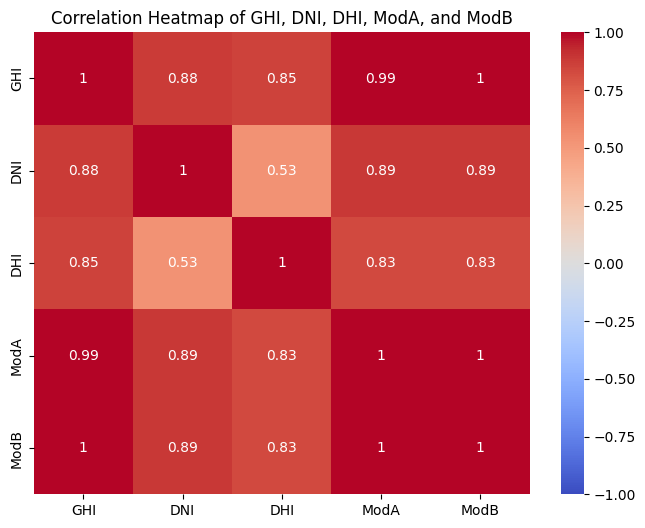

In [27]:
# 1. Correlation Heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = df_clean[corr_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of GHI, DNI, DHI, ModA, and ModB')
plt.show()

The near-perfect correlations (0.99-1.0) between GHI, ModA, and ModB indicate these variables are highly consistent, likely due to effective data cleaning or identical measurement methods. This contrasts with the moderate DNI-DHI correlation (0.53), reflecting their distinct contributions to GHI.

The perfect ModA-ModB correlation (1.0) suggests they may be duplicate measurements, which could be validated by checking sensor metadata or data sources.

##### Scatter plot

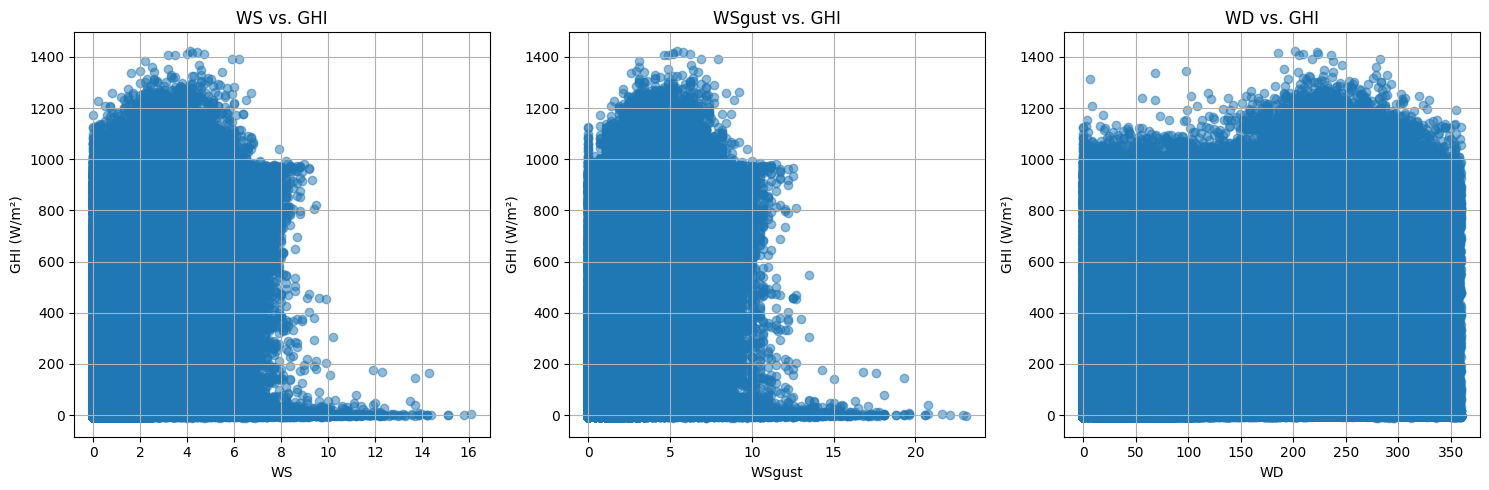

In [28]:
# 2. Scatter Plots
# a) WS, WSgust, WD vs. GHI
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, col in zip(axes, ['WS', 'WSgust', 'WD']):
    ax.scatter(df_clean[col], df_clean['GHI'], alpha=0.5)
    ax.set_title(f'{col} vs. GHI')
    ax.set_xlabel(col)
    ax.set_ylabel('GHI (W/m²)')
    ax.grid(True)
plt.tight_layout()
plt.show()

Wind speed doesn’t directly correlate with GHI. High GHI at low WS suggests calm, sunny conditions, while scattered high WS with low GHI might indicate windy, cloudy days. The lack of a trend aligns with expectations—wind speed influences cloud movement but isn’t a direct driver of irradiance.

Gust speed (WSgust) mirrors WS, showing no clear relationship with GHI. Gusts might briefly affect local weather (e.g., clearing clouds), but the effect isn’t systematic in this dataset.

Wind direction doesn’t directly influence GHI in a linear way. In Benin, local weather patterns (e.g., monsoon winds) might affect cloud cover, but this scatter plot doesn’t reveal a strong directional trend. A wind rose or time-based analysis might uncover more.

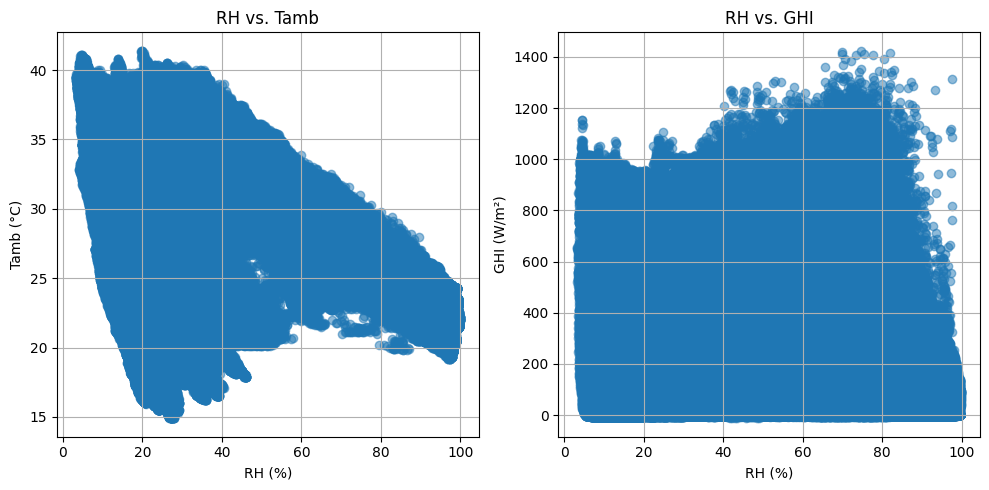

In [29]:
# b) RH vs. Tamb and RH vs. GHI
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(df_clean['RH'], df_clean['Tamb'], alpha=0.5)
axes[0].set_title('RH vs. Tamb')
axes[0].set_xlabel('RH (%)')
axes[0].set_ylabel('Tamb (°C)')
axes[0].grid(True)
axes[1].scatter(df_clean['RH'], df_clean['GHI'], alpha=0.5)
axes[1].set_title('RH vs. GHI')
axes[1].set_xlabel('RH (%)')
axes[1].set_ylabel('GHI (W/m²)')
axes[1].grid(True)
plt.tight_layout()
plt.show()

Higher humidity often cools the air through evaporative effects or cloud cover, reducing Tamb. Conversely, dry conditions (low RH) allow more solar heating, increasing Tamb. This inverse relationship is expected in a tropical climate like Togo’s.

High humidity often indicates cloud cover or rain, reducing GHI by blocking sunlight. Low humidity suggests clear skies, allowing maximum GHI. This strong inverse relationship highlights humidity’s role in solar irradiance variability.

Overall Insights
Solar Variables: GHI, DNI, ModA, and ModB are tightly correlated, confirming the dataset’s reliability for solar analysis. DHI is less correlated, reflecting its diffuse nature.
Wind Impact: WS, WSgust, and WD show no strong linear relationship with GHI, suggesting wind doesn’t directly drive irradiance but might influence it indirectly (e.g., via cloud movement).
Humidity Effects: RH has a significant inverse effect on both Tamb and GHI, aligning with expectations—humid conditions reduce temperature and irradiance due to clouds or rain.

#### Enhance Scatterplot

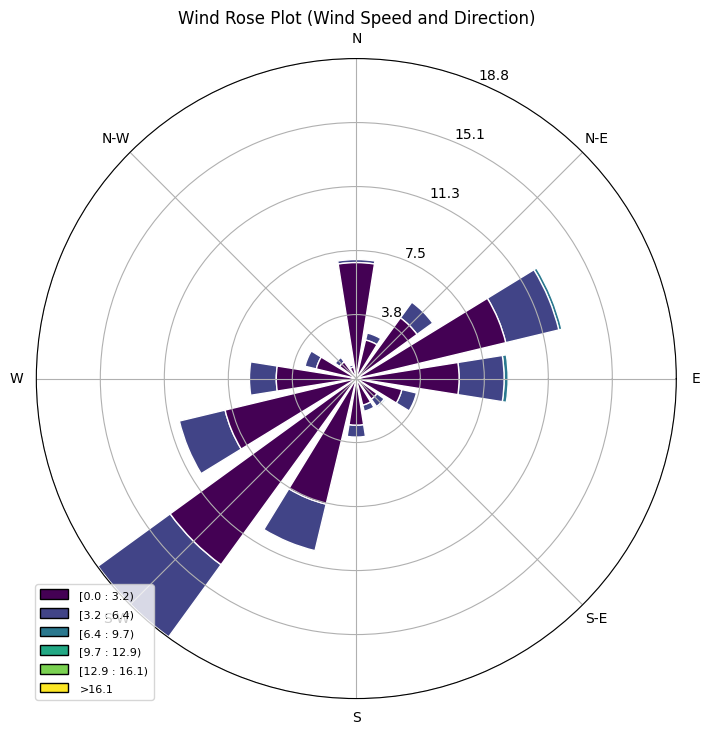

In [30]:
# Wind Analysis:understand directional patterns
from windrose import WindroseAxes
fig = plt.figure(figsize=(8, 8))
ax = WindroseAxes.from_ax(fig=fig)
ax.bar(df_clean['WD'], df_clean['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title('Wind Rose Plot (Wind Speed and Direction)')
plt.show()

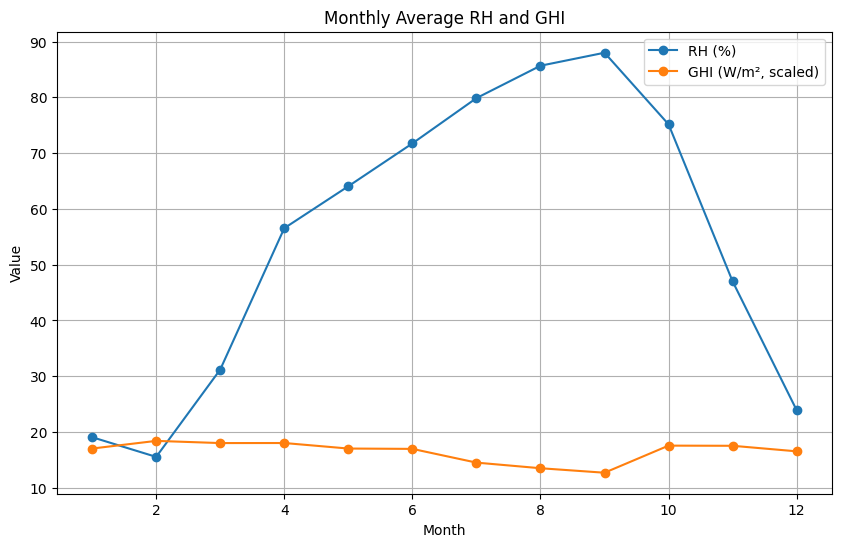

In [32]:
# Calculate monthly averages for RH and GHI
df_clean['Month'] = df_clean.index.month
monthly_rh_ghi = df_clean.groupby('Month')[['RH', 'GHI']].mean()

# Plot to confirm (recreating the Monthly Average RH and GHI plot)
plt.figure(figsize=(10, 6))
plt.plot(monthly_rh_ghi.index, monthly_rh_ghi['RH'], label='RH (%)', marker='o')
plt.plot(monthly_rh_ghi.index, monthly_rh_ghi['GHI'] / 14, label='GHI (W/m², scaled)', marker='o')
plt.title('Monthly Average RH and GHI')
plt.xlabel('Month')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

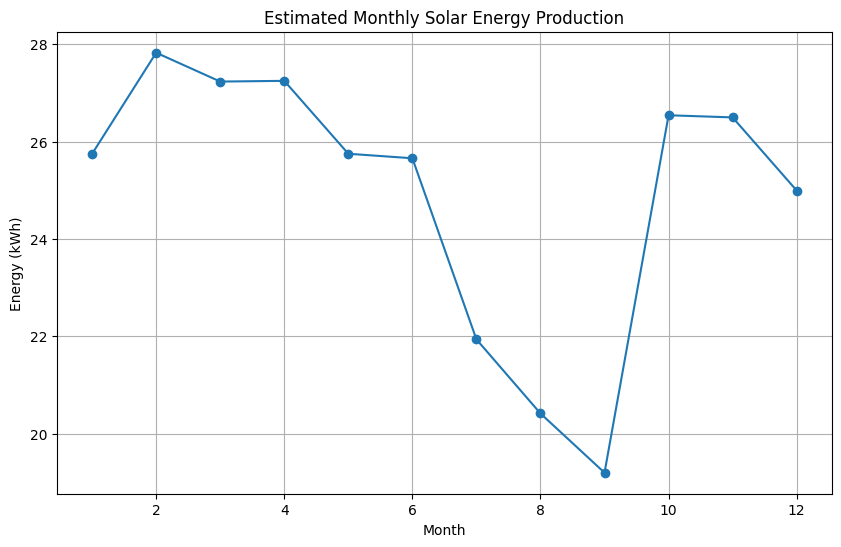


Estimated Monthly Solar Energy Production (kWh):
Month
1     25.750107
2     27.827152
3     27.234282
4     27.249186
5     25.750733
6     25.658221
7     21.936245
8     20.413861
9     19.195872
10    26.541950
11    26.497788
12    24.994996
Name: GHI, dtype: float64


In [33]:
# Energy Production Estimate
panel_area = 1  # m² (example)
efficiency = 0.15  # 15%
monthly_energy = monthly_rh_ghi['GHI'] * panel_area * efficiency * 24 * 30 / 1000  # kWh/month
plt.figure(figsize=(10, 6))
plt.plot(monthly_energy.index, monthly_energy, label='Energy (kWh)', marker='o')
plt.title('Estimated Monthly Solar Energy Production')
plt.xlabel('Month')
plt.ylabel('Energy (kWh)')
plt.grid(True)
plt.show()

# Display the energy values
print("\nEstimated Monthly Solar Energy Production (kWh):")
print(monthly_energy)

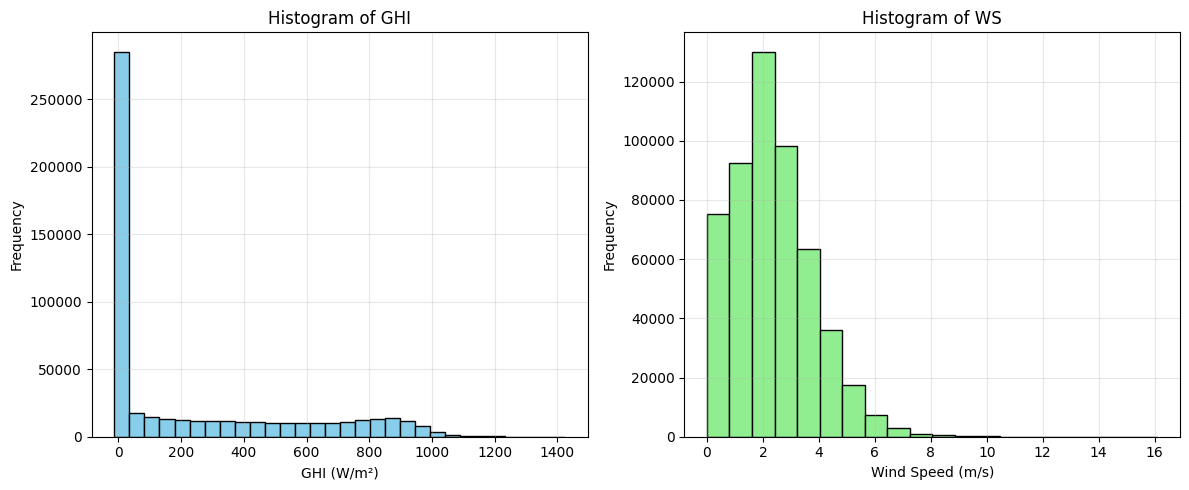

In [35]:
# 2. Histograms for GHI and WS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram for GHI
ax1.hist(df_clean['GHI'], bins=30, color='skyblue', edgecolor='black')
ax1.set_title('Histogram of GHI')
ax1.set_xlabel('GHI (W/m²)')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)

# Histogram for WS
ax2.hist(df_clean['WS'], bins=20, color='lightgreen', edgecolor='black')
ax2.set_title('Histogram of WS')
ax2.set_xlabel('Wind Speed (m/s)')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

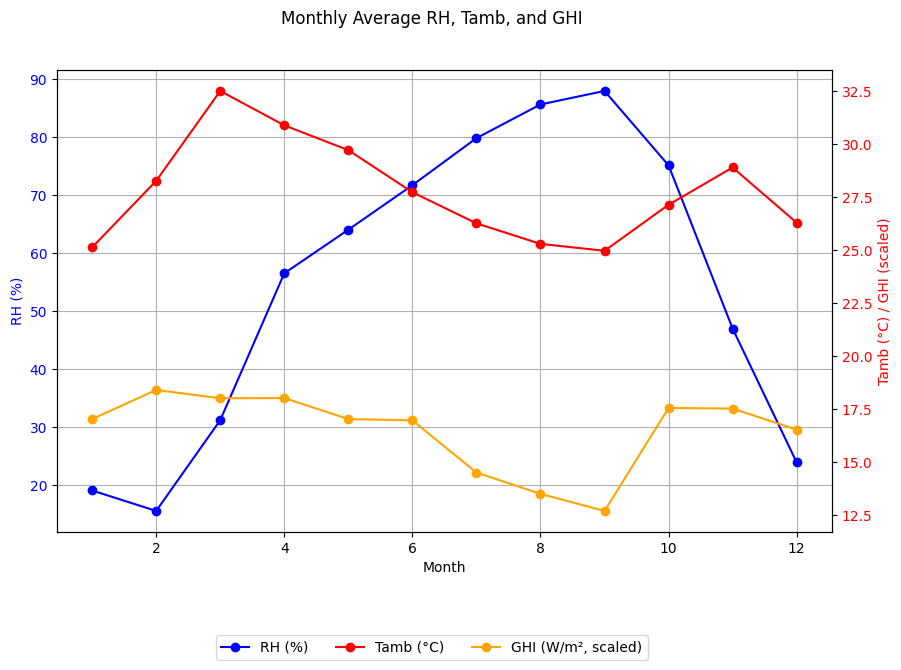

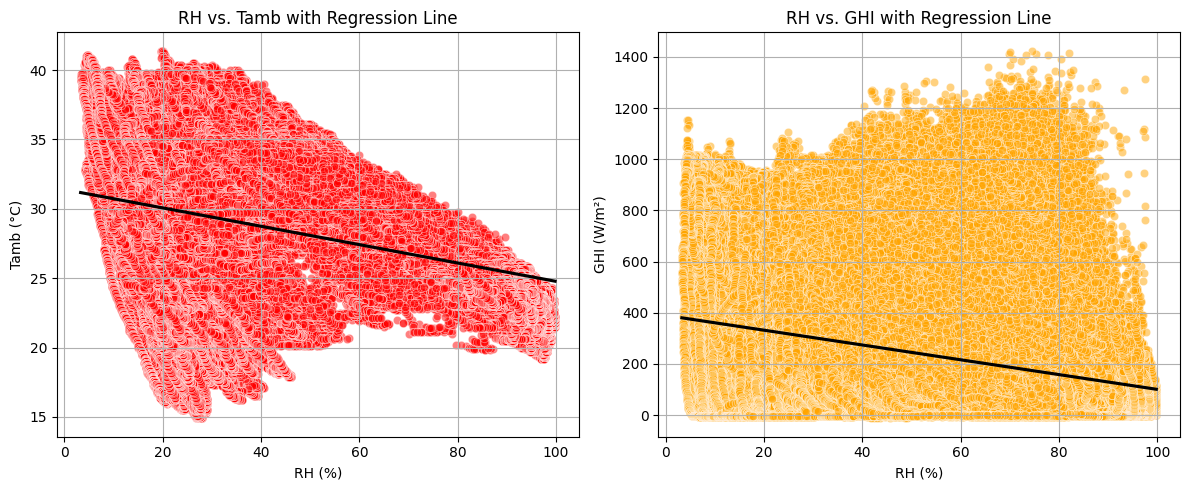


Correlation Coefficients:
            RH      Tamb       GHI
RH    1.000000 -0.400410 -0.258077
Tamb -0.400410  1.000000  0.562533
GHI  -0.258077  0.562533  1.000000


In [36]:


# 1. Monthly Averages of RH, Tamb, and GHI
df_clean['Month'] = df_clean.index.month
monthly_avg = df_clean.groupby('Month')[['RH', 'Tamb', 'GHI']].mean()

# Plot monthly trends
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(monthly_avg.index, monthly_avg['RH'], label='RH (%)', color='blue', marker='o')
ax1.set_xlabel('Month')
ax1.set_ylabel('RH (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(monthly_avg.index, monthly_avg['Tamb'], label='Tamb (°C)', color='red', marker='o')
ax2.plot(monthly_avg.index, monthly_avg['GHI'] / 14, label='GHI (W/m², scaled)', color='orange', marker='o')
ax2.set_ylabel('Tamb (°C) / GHI (scaled)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.suptitle('Monthly Average RH, Tamb, and GHI')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)
plt.show()

# 2. Scatter Plots with Regression Lines
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# RH vs. Tamb
sns.scatterplot(data=df_clean, x='RH', y='Tamb', ax=ax1, alpha=0.5, color='red')
sns.regplot(data=df_clean, x='RH', y='Tamb', ax=ax1, scatter=False, color='black')
ax1.set_title('RH vs. Tamb with Regression Line')
ax1.set_xlabel('RH (%)')
ax1.set_ylabel('Tamb (°C)')
ax1.grid(True)

# RH vs. GHI
sns.scatterplot(data=df_clean, x='RH', y='GHI', ax=ax2, alpha=0.5, color='orange')
sns.regplot(data=df_clean, x='RH', y='GHI', ax=ax2, scatter=False, color='black')
ax2.set_title('RH vs. GHI with Regression Line')
ax2.set_xlabel('RH (%)')
ax2.set_ylabel('GHI (W/m²)')
ax2.grid(True)

plt.tight_layout()
plt.show()

# 3. Correlation Coefficients (for reference)
print("\nCorrelation Coefficients:")
print(df_clean[['RH', 'Tamb', 'GHI']].corr())

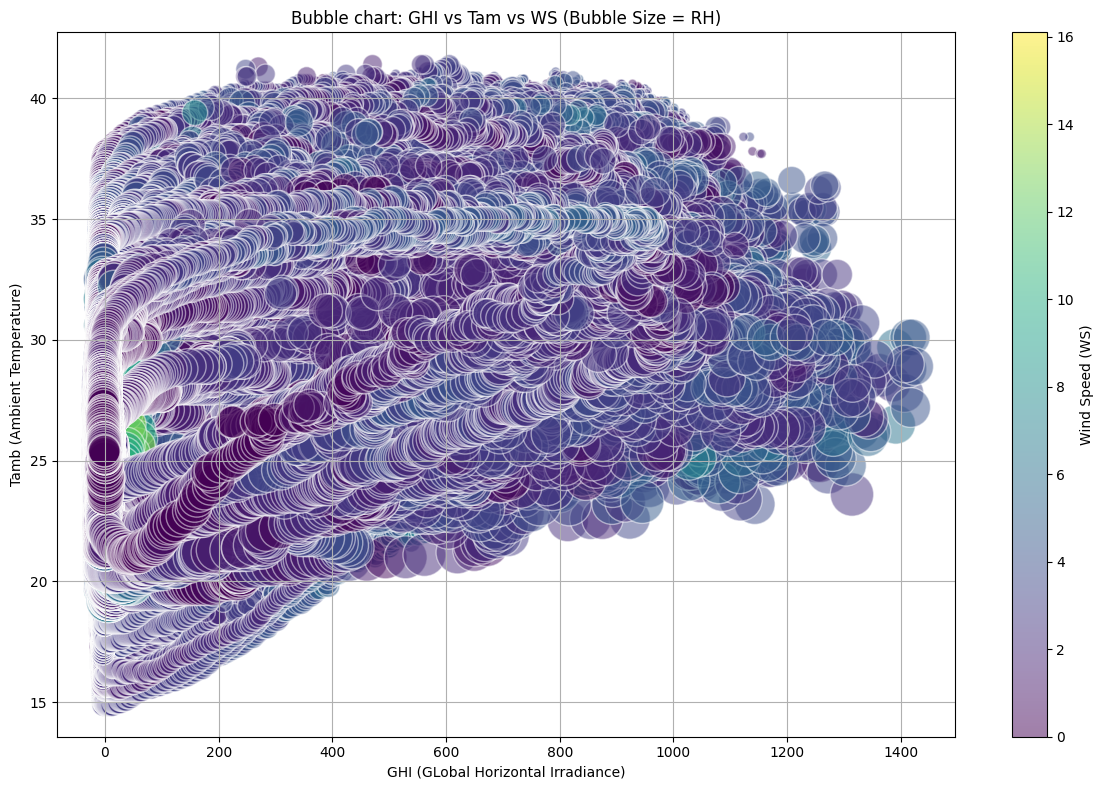

In [37]:
# Bubble charts

bubble_data = df_clean[['GHI', 'Tamb', 'WS', 'RH', 'BP']]

plt.figure(figsize=(12,8))

bubble_size = bubble_data['RH'] * 10
plt.scatter(bubble_data["GHI"], bubble_data['Tamb'], s=bubble_size, alpha=0.5, c=bubble_data['WS'], cmap='viridis', edgecolors='w')

plt.title("Bubble chart: GHI vs Tam vs WS (Bubble Size = RH)")
plt.xlabel("GHI (GLobal Horizontal Irradiance)")
plt.ylabel('Tamb (Ambient Temperature)')
plt.colorbar(label='Wind Speed (WS)')

plt.grid()
plt.tight_layout()
plt.show()